# Lyft Perception Challenge

## Challenge Overview

Your goal in this challenge is pixel-wise identification of objects in camera images. In other words, your task is to identify exactly what is in each pixel of an image! More specifically, you'll be identifying cars and the drivable area of the road. The images below are a simulated camera image on the left and a label image on the right, where each different type of object in the image corresponds to a different color.

![Example image and pixel-wise labels](overview.png)

In [22]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Data Exploration

For this challenge you will train your perception algorithm using data from the [CARLA](http://carla.org/) simulator. You can download the data [here](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/Lyft_Challenge/Training+Data/lyft_training_data.tar.gz). The dataset consists of images and the corresponding ground truth pixel-wise labels for each image.

In [23]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [24]:
PATH = 'data/'

In [25]:
os.listdir(PATH)

['.DS_Store', 'CameraRGB', 'CameraSeg', 'testing', 'training', 'vgg']

In [26]:
images = os.listdir(f'{PATH}CameraRGB')[:5]
labels = os.listdir(f'{PATH}CameraSeg')[:5]

In [27]:
sample_img = plt.imread(f'{PATH}CameraRGB/{images[0]}', format='PNG')
label_img = plt.imread(f'{PATH}CameraSeg/{labels[0]}', format='PNG')

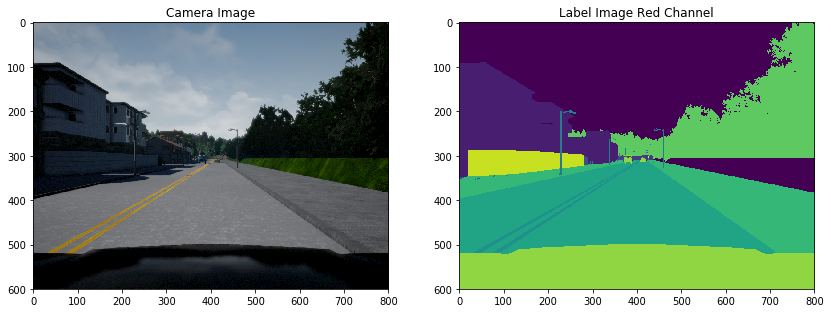

In [28]:
plt.figure(figsize=(14,12))
plt.subplot(121)
plt.title("Camera Image")
plt.imshow(sample_img)
plt.subplot(122)
plt.title("Label Image Red Channel")
plt.imshow(label_img[:,:,0])

## Preprocessing Ground Truth Labels

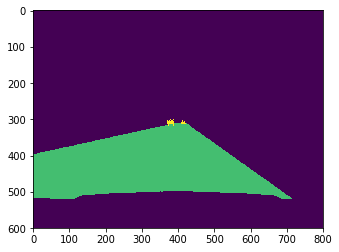

In [29]:
def preprocess(img):
    res = np.copy(img)
    # lane to road
    res[res==6] = 7
    # set all zero except road and vehicle
    res[(res!=7)&(res!=10)] = 0
    # Hood to zero
    res[490:,:,:][res[490:,:,:]==10] = 0
    return res

plt.imshow(preprocess(label_img)[:,:,0])

## FCN8 with VGG16

First, I'll label the pixels in images using FCN8. A pre-trained VGG16(which is downloadable [here](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip) is used as an encoder. 

In [30]:
import tensorflow as tf
from glob import glob
import re
import random
import skimage.transform
import imageio

### Load Pretrained VGG Model into TensorFlow

In [31]:
def load_vgg(sess, path):
    # load the model and weights
    tf.saved_model.loader.load(sess, ['vgg16'], path)
  
    # Get Tensors to be returned from graph
    graph = tf.get_default_graph()
    image_input = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    layer3 = graph.get_tensor_by_name('layer3_out:0')
    layer4 = graph.get_tensor_by_name('layer4_out:0')
    layer7 = graph.get_tensor_by_name('layer7_out:0')

    return image_input, keep_prob, layer3, layer4, layer7

### Create the layers for a FCN

In [32]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    l2_regularizer = tf.contrib.layers.l2_regularizer(1e-3)

    # Add the 1x1 layers
    l7 = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, padding='same', kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
    l4 = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, padding='same', kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
    l3 = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, padding='same', kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
    
    # Upsampling
    out = tf.layers.conv2d_transpose(l7, num_classes, 4, 2, 'same', kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
    
    # Skip-layer + upsampling
    out = tf.add(out, l4)
    out = tf.layers.conv2d_transpose(out, num_classes, 4, 2, 'same', kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
    
    # Skip-layer + upsampling
    out = tf.add(out, l3)
    out = tf.layers.conv2d_transpose(out, num_classes, 16, 8, 'same', kernel_initializer=he_init, kernel_regularizer=l2_regularizer, name='prediction')

    return out

### Build the TensorFLow loss and optimizer operations

In [33]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    # Reshape 4D tensors to 2D
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    correct_label = tf.reshape(correct_label, (-1, num_classes))
    
    # Calculate loss using cross entropy
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=correct_label[:])
    loss = tf.reduce_mean(cross_entropy)

    # Adam Optimizer
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

    return logits, train_op, loss

### Define the train_nn function

In [34]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    print("Training start...")
    for epoch in range(epochs):
        print("Epoch: {}/{}".format(epoch+1, epochs))
        for batch, (images, labels) in enumerate(get_batches_fn(batch_size)):
            feed_dict = {input_image: images, correct_label: labels, keep_prob: 0.75, learning_rate: 1e-3}
            _, loss = sess.run([train_op, cross_entropy_loss], feed_dict=feed_dict)
            print("  Batch: {}, Training Loss: {:.4f}".format(batch+1, loss))

### Create function to get batches

In [35]:
def gen_batch_function(data_folder, image_shape):
    def get_batches_fn(batch_size):
        image_paths = glob(os.path.join(data_folder, 'CameraRGB', '*.png'))
        label_paths = {
            os.path.basename(path): path
            for path in glob(os.path.join(data_folder, 'CameraSeg', '*.png'))}

        random.shuffle(image_paths)
        for batch_i in range(0, len(image_paths), batch_size):
            images = []
            gt_images = []
            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                image = skimage.transform.resize(imageio.imread(image_file), image_shape)
                gt_image = skimage.transform.resize(imageio.imread(gt_image_file), image_shape)
                gt_image = preprocess(gt_image)
                gt_bg = np.all(gt_image == [0, 0, 0], axis=2)
                gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
                gt_vehicle = np.all(gt_image == [0, 0, 10], axis=2)
                gt_vehicle = gt_vehicle.reshape(*gt_vehicle.shape, 1)
                gt_road = np.all(gt_image == [0, 0, 7], axis=2)
                gt_road = gt_road.reshape(*gt_road.shape, 1)
                gt_image = np.concatenate((gt_bg, gt_vehicle, gt_road), axis=2)
                
                images.append(image)
                gt_images.append(gt_image)

            yield np.array(images), np.array(gt_images)
    return get_batches_fn

### Training

In [36]:
num_classes = 3
image_shape = (320, 576)
epochs = 1#40
batch_size = 16
data_dir = './data'

# Path to vgg model
vgg_path = os.path.join(data_dir, 'vgg')
# Create function to get batches
get_batches_fn = gen_batch_function(os.path.join(data_dir, ''), image_shape)

with tf.Session() as sess:
    image_input, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path)
    model = layers(layer3_out, layer4_out, layer7_out, num_classes)
    
    correct_label = tf.placeholder(tf.float32, [None, None, None, num_classes])
    learning_rate = tf.placeholder(tf.float32)
    logits, train_op, cross_entropy_loss = optimize(model, correct_label, learning_rate, num_classes)
    
    sess.run(tf.global_variables_initializer())
    train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, image_input, correct_label, keep_prob, learning_rate)
    
    saver = tf.train.Saver()
    saver.save(sess, "model/model.ckpt")

INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'


ValueError: GraphDef cannot be larger than 2GB.

/Users/barney/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


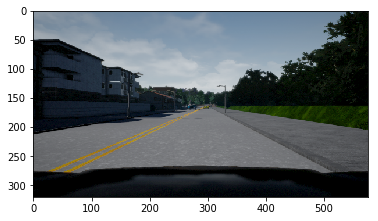

In [15]:
num_classes = 3
image_shape = (320, 576)

test_image = skimage.transform.resize(sample_img, image_shape)
plt.imshow(test_image)

In [21]:
num_classes = 3
image_shape = (320, 576)

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./model/model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./model'))
    
    graph = tf.get_default_graph()
    image_input = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    last_layer = graph.get_tensor_by_name('prediction:0')
#     logits = tf.reshape(last_layer, (-1, num_classes))
    
#     im_softmax = sess.run([tf.nn.softmax(logits)], {keep_prob: 1.0, image_input: [test_image]})
    
#     print(im_softmax)

INFO:tensorflow:Restoring parameters from ./model/model.ckpt


ValueError: GraphDef cannot be larger than 2GB.